In [1]:
# %% [markdown]
# # Tango sales and profitability analysis using linear regression
#
# This notebook demonstrates building or loading a dataset for Tango,
# preparing features from sales, profit margins, and demographics, 
# then fitting a linear regression model to explore drivers of sales or profits.

# %% [code]
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Optional: display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

In [2]:
# %% [markdown]
# ## 2. Generate a synthetic dataset
# The dataset will include:
# - sales: monthly sales in USD
# - profit_margin: percent margin for the month
# - region: categorical (NA, Europe, Asia-Pacific, Global)
# - income_level: categorical or numeric income band of typical customer in that region
# - avg_age: average age of customers (numeric)
# - gender_ratio_male: ratio of male customers, 0-1
# - location_type: categorical (Urban, Suburban, Rural)
# - month: datetime index for a custom time range
# - additional noise

# %% [code]
np.random.seed(42)

n_months = 120  # 10 years of monthly data
date_range = pd.date_range(start='2015-01-01', periods=n_months, freq='MS')

# Regions distribution
regions = ['North America', 'Europe', 'Asia-Pacific', 'Global']
region_probs = [0.4, 0.3, 0.2, 0.1]

# Location types
location_types = ['Urban', 'Suburban', 'Rural']

data_list = []
for dt in date_range:
    for _ in range(5):  # 5 data points per month to create some variation
        region = np.random.choice(regions, p=region_probs)
        
        # Synthetic customer demographics
        # Income level numeric (e.g., average household income in $k)
        if region == 'North America':
            income_level = np.random.normal(70, 15)  # in $k
        elif region == 'Europe':
            income_level = np.random.normal(60, 12)
        elif region == 'Asia-Pacific':
            income_level = np.random.normal(45, 10)
        else:  # Global
            income_level = np.random.normal(50, 20)

        avg_age = np.random.normal(35, 8)
        gender_ratio_male = np.clip(np.random.beta(2, 2), 0, 1)
        location_type = np.random.choice(location_types, p=[0.5, 0.3, 0.2])

        # Sales and profit margins
        base_sales = {
            'North America': 200000,
            'Europe': 150000,
            'Asia-Pacific': 100000,
            'Global': 50000
        }[region]

        # Seasonal effect: higher sales in Q4
        month_factor = 1 + 0.2 * (dt.month in [11,12])

        # Income effect
        income_factor = 1 + (income_level - 50) / 200  # mild scaling

        sales = base_sales * month_factor * income_factor * np.random.uniform(0.8, 1.2)
        
        # Profit margin influenced by income, location type, randomness
        profit_margin = 0.20 + (income_level - 50)/1000  # base 20% + small income effect
        if location_type == 'Urban':
            profit_margin += 0.01
        elif location_type == 'Rural':
            profit_margin -= 0.005
        profit_margin = np.clip(profit_margin, 0.05, 0.35)

        data_list.append({
            'date': dt,
            'region': region,
            'income_level_k': income_level,
            'avg_age': avg_age,
            'gender_ratio_male': gender_ratio_male,
            'location_type': location_type,
            'sales_usd': sales,
            'profit_margin': profit_margin
        })

df = pd.DataFrame(data_list)
df.head()

,date,region,income_level_k,avg_age,gender_ratio_male,location_type,sales_usd,profit_margin
0,2015-01-01,North America,53.321798,37.551217,0.380648,Rural,230358.932444,0.198322
1,2015-01-01,North America,63.048735,31.274162,0.902516,Suburban,182326.583885,0.213049
2,2015-01-01,North America,59.449843,17.883035,0.276344,Urban,218459.943912,0.219450
3,2015-01-01,North America,60.990420,32.666450,0.157212,Urban,245535.493014,0.220990
4,2015-01-01,North America,51.023213,43.735938,0.693474,Suburban,236363.009080,0.201023


In [3]:
# %% [markdown]
# ## 3. Inspect data quality

# %% [code]
print(df.info())
print(df.describe())

# Check for duplicates or missing values
print(df.isna().sum())

# If there were any missing values, you could decide to fill or drop:
# df = df.dropna()  # or df.fillna(...)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               600 non-null    datetime64[ns]
 1   region             600 non-null    object        
 2   income_level_k     600 non-null    float64       
 3   avg_age            600 non-null    float64       
 4   gender_ratio_male  600 non-null    float64       
 5   location_type      600 non-null    object        
 6   sales_usd          600 non-null    float64       
 7   profit_margin      600 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 37.6+ KB
None
                      date  income_level_k     avg_age  gender_ratio_male  \
count                  600      600.000000  600.000000         600.000000   
mean   2019-12-16 10:48:00       60.950512   34.818329           0.495987   
min    2015-01-01 00:00:00       11.62

In [4]:
# %% [markdown]
# ## 4. Apply custom filters
# Example: user chooses a custom period, e.g., 2018-01-01 to 2023-12-31
start_date = '2018-01-01'
end_date = '2023-12-31'

df_filtered = df[
    (df['date'] >= start_date) & 
    (df['date'] <= end_date) &
    (df['region'].isin(['North America', 'Europe', 'Global', 'Asia-Pacific']))
].copy()

df_filtered['year'] = df_filtered['date'].dt.year
df_filtered['month'] = df_filtered['date'].dt.month

df_filtered.head()

,date,region,income_level_k,avg_age,gender_ratio_male,location_type,sales_usd,profit_margin,year,month
180,2018-01-01,Asia-Pacific,42.231867,33.663026,0.352846,Suburban,102119.789823,0.192232,2018,1
181,2018-01-01,North America,67.899357,37.610197,0.432599,Urban,218409.476434,0.227899,2018,1
182,2018-01-01,Asia-Pacific,38.486431,37.470664,0.957511,Suburban,108316.476340,0.188486,2018,1
183,2018-01-01,Europe,60.941153,30.020974,0.626126,Urban,161691.769403,0.220941,2018,1
184,2018-01-01,Asia-Pacific,36.494795,25.432936,0.529482,Suburban,75914.994967,0.186495,2018,1


In [6]:
# %% [markdown]
# ## 5. Feature engineering

# Choose target
target_var = 'sales_usd'  # or 'profit_margin'

# One-hot encode region and location_type
df_model = pd.get_dummies(
    df_filtered,
    columns=['region', 'location_type'],
    drop_first=True
)

# Automatically collect generated dummy columns
region_dummies = [col for col in df_model.columns if col.startswith('region_')]
location_dummies = [col for col in df_model.columns if col.startswith('location_type_')]

# Define feature list
features = [
    'income_level_k',
    'avg_age',
    'gender_ratio_male'
] + region_dummies + location_dummies

# Keep only available columns (extra safety)
features = [col for col in features if col in df_model.columns]

# Final modeling dataframe
df_model = df_model[features + [target_var]]

df_model.head()

,income_level_k,avg_age,gender_ratio_male,region_Europe,region_Global,region_North America,location_type_Suburban,location_type_Urban,sales_usd
180,42.231867,33.663026,0.352846,False,False,False,True,False,102119.789823
181,67.899357,37.610197,0.432599,False,False,True,False,True,218409.476434
182,38.486431,37.470664,0.957511,False,False,False,True,False,108316.476340
183,60.941153,30.020974,0.626126,True,False,False,False,True,161691.769403
184,36.494795,25.432936,0.529482,False,False,False,True,False,75914.994967


In [7]:
# %% [markdown]
# ## 6. Train-test split

X = df_model[features]
y = df_model[target_var]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (288, 8)
Test shape: (72, 8)


In [8]:
# %% [markdown]
# ## 7. Fit a simple linear regression model

lr = LinearRegression()
lr.fit(X_train, y_train)

# Coefficients
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': lr.coef_
}).sort_values(by='coefficient', key=abs, ascending=False)

coef_df

,feature,coefficient
5,region_North America,110366.630043
4,region_Global,-48915.888678
3,region_Europe,48783.285850
6,location_type_Suburban,-3250.919944
0,income_level_k,939.713317
2,gender_ratio_male,-482.707421
7,location_type_Urban,-200.991324
1,avg_age,143.148879


In [9]:
# %% [markdown]
# ## 8. Evaluate on test set

y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.2f}")
print(f"R^2: {r2:.3f}")

RMSE: 24,225.13
R^2: 0.870


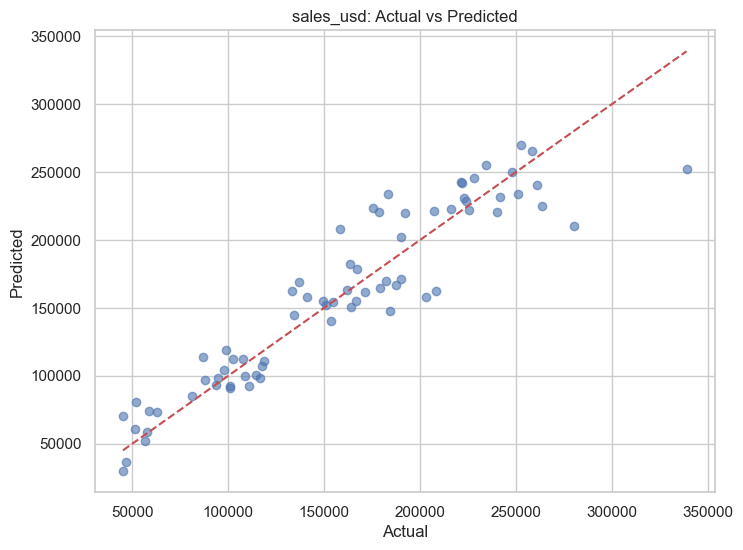

In [10]:
# %% [markdown]
# ## 9. Plot results

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'{target_var}: Actual vs Predicted')
plt.show()

In [11]:
# %% [markdown]
# ## 10. Interpret coefficients
# Positive coefficient: as feature increases, target tends to increase.
# Negative: inverse relationship.

coef_df

,feature,coefficient
5,region_North America,110366.630043
4,region_Global,-48915.888678
3,region_Europe,48783.285850
6,location_type_Suburban,-3250.919944
0,income_level_k,939.713317
2,gender_ratio_male,-482.707421
7,location_type_Urban,-200.991324
1,avg_age,143.148879


In [12]:
# %% [markdown]
# Example: add interaction income * region_Europe
df_model['income_Europe'] = df_model['income_level_k'] * df_model.get('region_Europe', 0)
# Refit model as needed...

In [17]:
import pandas as pd

# Load dataset
df_real = pd.read_csv('tango_sales_demographics.csv')

# Clean column names (remove hidden spaces)
df_real.columns = df_real.columns.str.strip()

# Automatically detect a date column
date_columns = [col for col in df_real.columns if 'date' in col.lower()]

if date_columns:
    # Convert first detected date column to datetime
    df_real[date_columns[0]] = pd.to_datetime(df_real[date_columns[0]], errors='coerce')
    print(f"Date column parsed: {date_columns[0]}")
else:
    print("No date column found in dataset.")

# Show first rows
print(df_real.head())

Date column parsed: Purchase_Date
   Customer_ID  Age  Gender    Country  Purchase_Amount_USD Product_Category  \
0         1001   25  Female        USA               120.50            Shoes   
1         1002   34    Male         UK                89.99          Apparel   
2         1003   29  Female  Argentina               150.00            Shoes   
3         1004   45    Male     Canada               200.75      Accessories   
4         1005   52  Female        USA               175.20          Apparel   

  Purchase_Date  
0    2025-01-15  
1    2025-01-18  
2    2025-01-20  
3    2025-01-22  
4    2025-01-25  
